<a href="https://colab.research.google.com/github/Anuj-ipynb/AgroPred/blob/main/Agropred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer

##Creating a DataFrame

In [ ]:
np.random.seed(42)
data = {
'Harvest_ID': np.arange(1, 501),
'Crop': np.random.choice(['Wheat', 'Corn', 'Soybean', 'Rice', 'Barley'], size=500),
'Yield': np.random.uniform(1.5, 10.0, size=500),
'Rainfall': np.random.uniform(0, 300, size=500),
'Temperature': np.random.uniform(10, 35, size=500),
'Harvest_Date': pd.date_range(start='2023-01-01', periods=500, freq='D'),
'Region': np.random.choice(['North', 'South', 'East', 'West', 'Central'], size=500),
'Pesticide_Usage': np.random.uniform(0, 1, size=500),
'Soil_Quality': np.random.choice(['Low', 'Medium', 'High'], size=500)
}
df = pd.DataFrame(data)
missing_samples = np.random.choice(df.index, size=int(0.1*len(df)), replace=False)
df.loc[missing_samples, 'Rainfall'] = np.nan
threshold = 5.0
df['High_Yield'] = (df['Yield'] > threshold).astype(int)
df['Rainfall'].fillna(df['Rainfall'].mean(), inplace=True)
le_crop = LabelEncoder()
le_region = LabelEncoder()
le_soil_quality = LabelEncoder()
df['Crop_encoded'] = le_crop.fit_transform(df['Crop'])
df['Region_encoded'] = le_region.fit_transform(df['Region'])
df['Soil_Quality_encoded'] = le_soil_quality.fit_transform(df['Soil_Quality'])
df.head()

<ipython-input-2-e97dad19c84e>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Rainfall'].fillna(df['Rainfall'].mean(), inplace=True)


,Harvest_ID,Crop,Yield,Rainfall,Temperature,Harvest_Date,Region,Pesticide_Usage,Soil_Quality,High_Yield,Crop_encoded,Region_encoded,Soil_Quality_encoded
0,1,Rice,5.794645,54.430631,10.916786,2023-01-01,South,0.438538,Low,1,2,3,1
1,2,Barley,8.524888,174.912468,28.410050,2023-01-02,South,0.218510,High,1,0,3,0
2,3,Soybean,4.220422,126.427365,26.595113,2023-01-03,West,0.396797,Low,0,3,4,1
3,4,Barley,9.111947,152.349953,21.865772,2023-01-04,North,0.044388,Medium,1,0,2,2
4,5,Barley,4.808214,245.233069,31.104261,2023-01-05,North,0.277822,Low,0,0,2,1


##Training and Splitting Data

In [ ]:
X = df[['Yield', 'Rainfall', 'Temperature', 'Pesticide_Usage', 'Crop_encoded', 'Region_encoded', 'Soil_Quality_encoded']]
y = df['High_Yield']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

#Hyperparameter Tuning

In [ ]:
pipeline = Pipeline([
('scaler', StandardScaler()),
('classifier', KNeighborsClassifier())
])
param_grid = [
{
'classifier': [KNeighborsClassifier()],
'classifier__n_neighbors': [3, 5, 7],
},
{
'classifier': [SVC()],
'classifier__C': [0.1, 1, 10],
'classifier__kernel': ['linear', 'rbf'],
},
{
'classifier': [RandomForestClassifier()],
'classifier__n_estimators': [50, 100, 200]
},
{
'classifier': [GradientBoostingClassifier()],
'classifier__n_estimators': [50, 100, 200]
}
]
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 15 candidates, totalling 75 fits


##Model Prediction after Model Selection

In [ ]:
y_pred = best_model.predict(X_test)
print(f"Best Model: {grid_search.best_params_}")
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best Model: {'classifier': RandomForestClassifier(), 'classifier__n_estimators': 200}
Model Accuracy: 0.9912280701754386

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        59
           1       0.98      1.00      0.99        55

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



##Plotting the Confusion Matrix

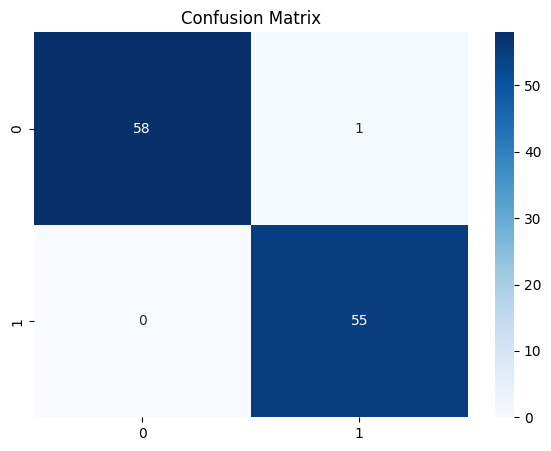

In [ ]:
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

##Printing Cross Validation Results

In [ ]:
cv_scores = cross_val_score(best_model, X, y, cv=5)
print("Cross-validation scores: ", cv_scores)
print("Mean CV score: ", np.mean(cv_scores))

Cross-validation scores:  [1.   1.   0.99 0.99 1.  ]
Mean CV score:  0.9960000000000001


##Model Selection and Basic Classification

In [ ]:
if isinstance(best_model.named_steps['classifier'], (RandomForestClassifier, GradientBoostingClassifier)):
  feature_importances = best_model.named_steps['classifier'].feature_importances_
  feature_names = X.columns
  sorted_idx = np.argsort(feature_importances)

##Visualising the results

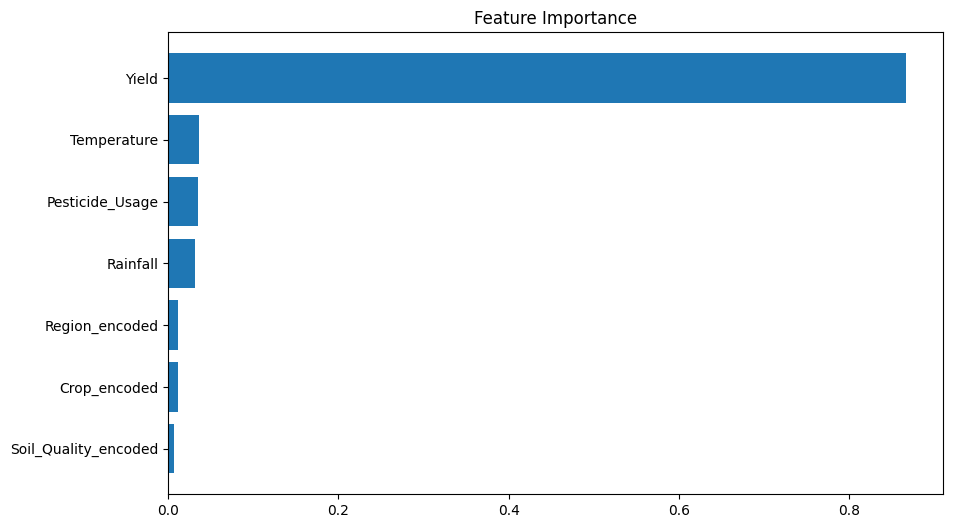

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], feature_importances[sorted_idx])
plt.title('Feature Importance')
plt.show()